In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import pickle
import os

In [26]:
base_dir = "../results/"
dataset = "IMDB"
model = "JWA"
samplers = ["random", "entropy", "anti_entropy"]
experiments = []
metas = []

for sampler in samplers:
    exp_id = f"{dataset}-{model}-{sampler}-all"
    for filename in os.listdir(base_dir):
        if filename.startswith(exp_id) and filename.endswith(".pkl"):
            with open(os.path.join(base_dir, filename), "rb") as f:
                results, meta = pickle.load(f)
                experiments.append(results)

meta["interpreters"] = ["grad-shap", "int-grad"]
meta["interpret_pairs"] = list(itertools.combinations(meta["interpreters"], 2))

In [27]:
len(experiments)

3

In [28]:
def plot_last_epoch(experiment, interpret_pairs):
    agreement_dict = defaultdict(list)
    train_scores = []
    eval_scores = []
    for (al_epoch, (L, A, T, E)) in enumerate(
        zip(
            experiment["labeled"], experiment["agreement"], experiment["train"], experiment["eval"]
        ),
        1,
    ):
        for ip in interpret_pairs:
            agreement_dict[ip].append(list(A)[-1][ip])
        train_scores.append(list(T)[-1]["loss"])
        eval_scores.append(list(E)[-1]["accuracy"]/100)

    fig, axs = plt.subplots(3, figsize=(12, 20), sharex=True)
    axs[0].scatter(experiment["labeled"], train_scores, color="r")
    axs[0].plot(experiment["labeled"], train_scores, color="r")
    axs[0].set_ylabel("Loss")
    axs[1].scatter(experiment["labeled"], eval_scores, color="g")
    axs[1].plot(experiment["labeled"], eval_scores, color="g")
    axs[1].set_ylabel("Accuracy")
    for ip, agrs in agreement_dict.items():
        axs[2].scatter(experiment["labeled"], agrs)
        axs[2].plot(experiment["labeled"], agrs)
        
    axs[2].set_ylabel("Agreement")
    axs[2].set_xlabel("# labeled")
    axs[2].legend(interpret_pairs)

In [34]:
def extract_last_epoch(experiments, interpret_pairs):
    dfs_tr = []
    dfs_agr = []
    for exp_index, experiment in enumerate(experiments):

        train = experiment["train"]
        train_vals = [tr[-1]["loss"] for tr in train]
        test = experiment["eval"]
        test_vals = [te[-1]["accuracy"] for te in test]
        labeled_vals = experiment["labeled"]
        iter_vals = list(range(len(labeled_vals)))
        df_tr = pd.DataFrame(
            {
                "al_iter": iter_vals,
                "labeled": labeled_vals,
                "train_loss": train_vals,
                "test_accuracy": test_vals,
            }
        )
        df_tr["experiment"] = exp_index
        df_tr.set_index(["experiment", "al_iter"], inplace=True)

        agreement_vals = []
        interpret_vals = []
        agreement = experiment["agreement"]
        for ip in interpret_pairs:
            for a in agreement:
                interpret_vals.append(ip)
                agreement_vals.append(a[-1][ip])

        df_agr = pd.DataFrame(
            {
                "al_iter": iter_vals * len(interpret_pairs),
                "labeled": labeled_vals * len(interpret_pairs),
                "agreement": agreement_vals,
                "interpreter": interpret_vals,
            }
        )
        df_agr["experiment"] = exp_index
        df_agr.set_index(["experiment", "al_iter", "interpreter"], inplace=True)

        dfs_tr.append(df_tr)
        dfs_agr.append(df_agr)
    new_df_tr = pd.concat(dfs_tr)
    new_df_agr = pd.concat(dfs_agr)
    return new_df_tr, new_df_agr


def plot_last_epoch_ci(experiments, meta, al_sampler):
    df_tr, df_agr = extract_last_epoch(experiments, meta["interpret_pairs"])
    fig, axs = plt.subplots(3, figsize=(12, 20), sharex=True)
    axs[0].set_title(f"{meta['dataset']} - {meta['model']} - {al_sampler}")
    sns.lineplot(ax=axs[0], data=df_tr, x="labeled", y="train_loss", color="r")
    sns.lineplot(ax=axs[1], data=df_tr, x="labeled", y="test_accuracy", color="g")
    sns.lineplot(
        ax=axs[2],
        data=df_agr,
        x="labeled",
        y="agreement",
        hue="interpreter",
        style="interpreter",
        markers=True,
        dashes=False,
    )
    plt.show()
    
    
def plot_al_accuracy(experiment_sets, meta, samplers, ci=95):
    dfs = []
    for exp_set, sampler in zip(experiment_sets, samplers):
        df_tr, _ = extract_last_epoch(exp_set, meta["interpret_pairs"])
        df_tr["sampler"] = sampler
        dfs.append(df_tr)

    data = pd.concat(dfs)
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=data,
        x="labeled",
        y="test_accuracy",
        hue="sampler",
        style="sampler",
        markers=True,
        dashes=False,
        ci=ci,
    )

def plot_al_agreement(experiment_sets, meta, samplers, ci=95):
    fig, axs = plt.subplots(len(meta["interpret_pairs"]), figsize=(12, 20))
    if type(axs) is not list:
        axs = [axs]
    for ip, ax in zip(meta["interpret_pairs"], axs):
        dfs = []
        for exp_set, sampler in zip(experiment_sets, samplers):
            _, df_agr = extract_last_epoch(exp_set, meta["interpret_pairs"])
            df_new = df_agr[df_agr.index.get_level_values("interpreter") == ip].copy()
            df_new["sampler"] = sampler
            dfs.append(df_new)
            
        agr_data = pd.concat(dfs)
        sns.lineplot(
            ax=ax,
            data=agr_data,
            x="labeled",
            y="agreement",
            hue="sampler",
            style="sampler",
            markers=True,
            dashes=False,
            picker=1,
            ci=ci,
        )
        ax.set_title(ip)

In [30]:
filt_ids = [0, 1, 2]
filt_exp = []
filt_samplers = []
for id_ in filt_ids:
    filt_exp.append(experiments[id_])
    filt_samplers.append(samplers[id_])

In [31]:
experiments[0]

[{'train': [[{'loss': 0.02174412366002798},
    {'loss': 0.0215652696788311},
    {'loss': 0.021371527574956417},
    {'loss': 0.02114003524184227},
    {'loss': 0.02081452589482069}],
   [{'loss': 0.02179364301264286},
    {'loss': 0.02131109358742833},
    {'loss': 0.020810953341424465},
    {'loss': 0.020015952177345753},
    {'loss': 0.01844348548911512}],
   [{'loss': 0.02164224684238434},
    {'loss': 0.02131843864917755},
    {'loss': 0.02067343071103096},
    {'loss': 0.018965428322553636},
    {'loss': 0.020108497142791747}],
   [{'loss': 0.021662173260535513},
    {'loss': 0.020955719852021763},
    {'loss': 0.02005245882485594},
    {'loss': 0.018522763890879496},
    {'loss': 0.016685000753828456}],
   [{'loss': 0.021594940219074488},
    {'loss': 0.021341930842027068},
    {'loss': 0.02109992573969066},
    {'loss': 0.0202514894772321},
    {'loss': 0.018923079478554428}],
   [{'loss': 0.021800304763019085},
    {'loss': 0.021218481473624706},
    {'loss': 0.02089479826390

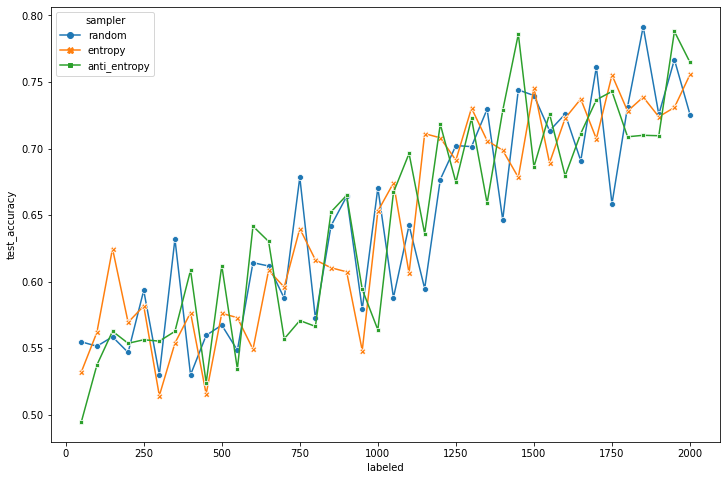

In [32]:
meta
plot_al_accuracy(experiments, meta, filt_samplers, ci=None)

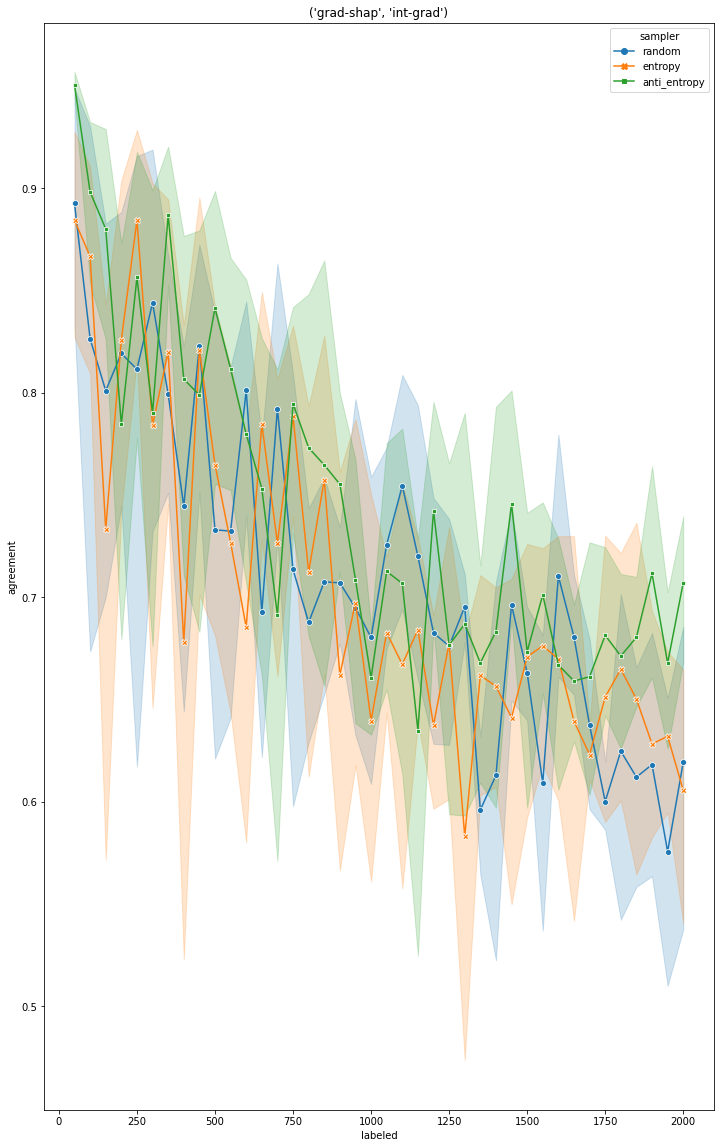

In [35]:
plot_al_agreement(experiments, meta, samplers)

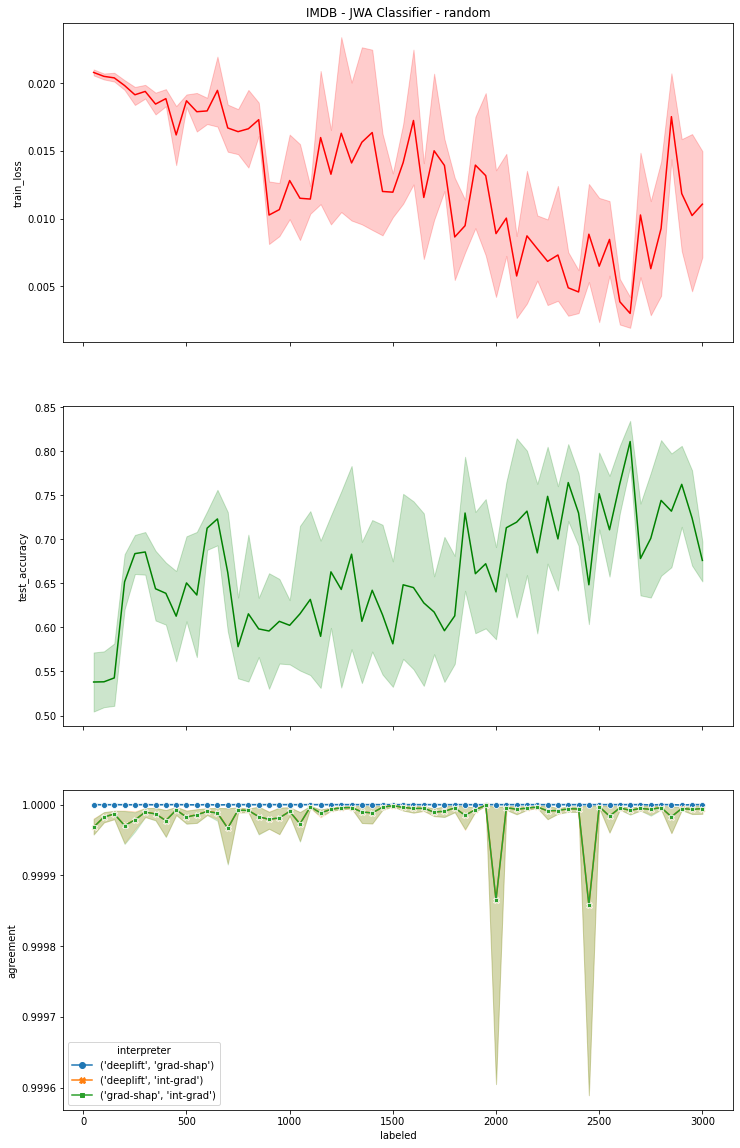

In [21]:
exp_id = 0
plot_last_epoch_ci(experiments[exp_id], meta, samplers[exp_id])

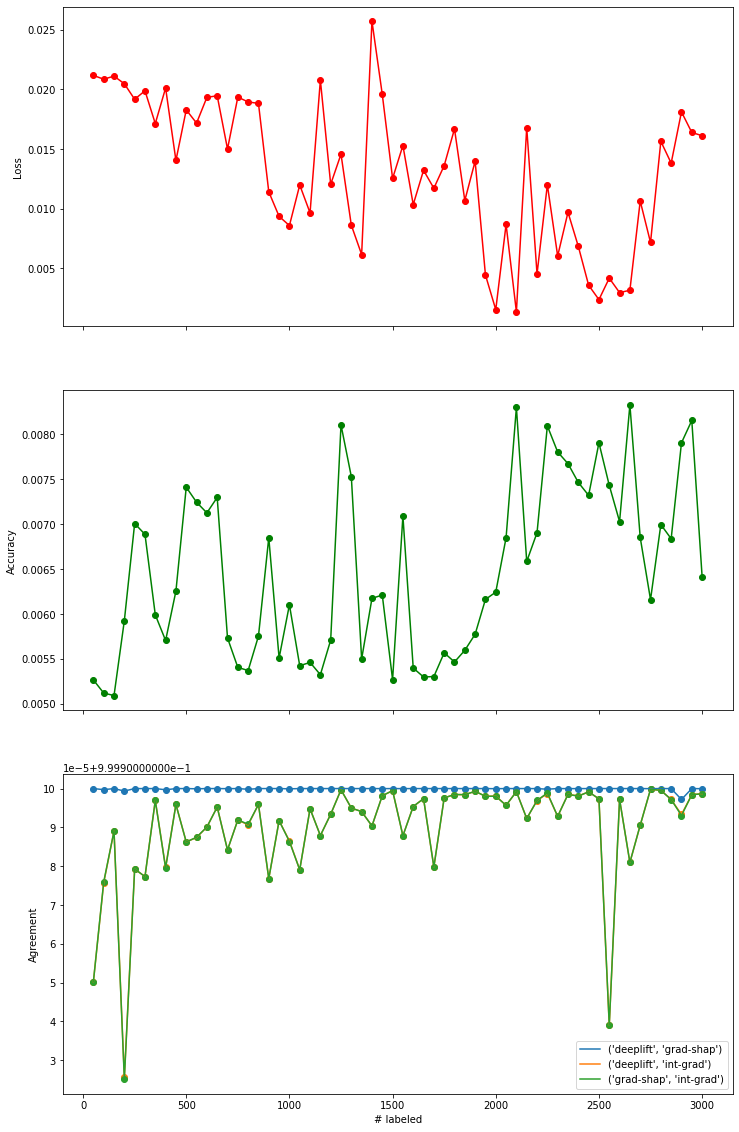

In [16]:
experiment_idx = 0
plot_last_epoch(experiments[experiment_idx][0], meta["interpret_pairs"])
plt.show()

In [17]:
def plot_epochwise_trend(results, interpreter):
    agreements = []
    for (al_epoch, (L, A, T, E)) in enumerate(
        zip(
            results["labeled"], results["agreement"], results["train"], results["eval"]
        ),
        1,
    ):

        for a in A:
            agreement = a[interpreter]
            if np.isnan(agreement):
                agreement = 0
            agreements.append(agreement)

    plt.figure(figsize=(20, 8))
    plt.scatter(range(len(agreements)), agreements)
    plt.plot(range(len(agreements)), agreements)
    plt.vlines(
        range(len(A), len(results["labeled"]) * len(A), len(A)),
        ymin=-0.2,
        ymax=1,
        color="r",
    )
    plt.ylabel("Agreeement")
    plt.title(interpreter)

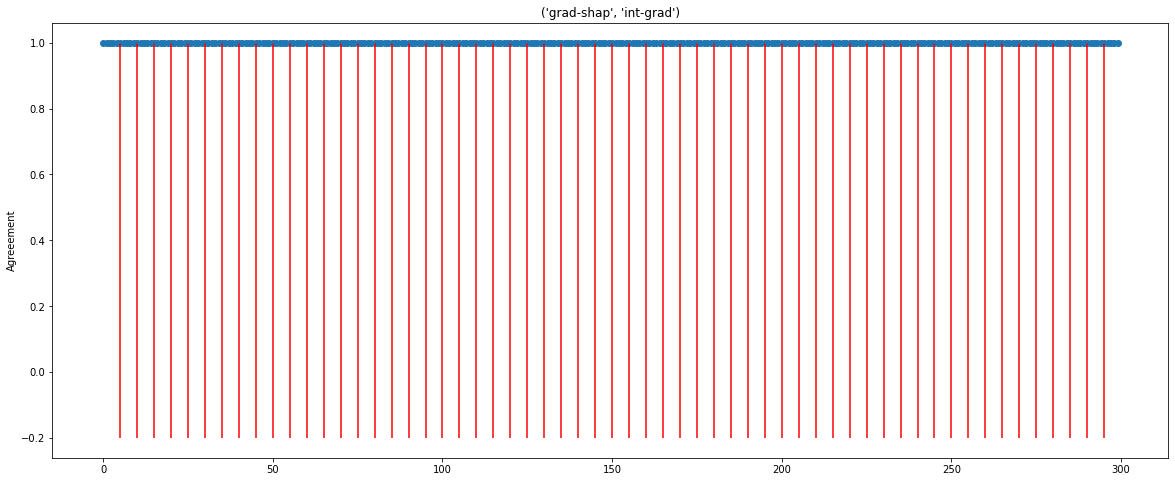

In [43]:
experiment_idx = 0
interpret_idx = 0
plot_epochwise_trend(experiments[experiment_idx][0], meta["interpret_pairs"][2])
plt.show()